In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv
/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_deposit_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_applprev_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_cb_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_3.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_tax_registry_b_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_2.parquet
/kaggle/input/home-credit-credit-risk-model-st

In [2]:
import sys
from pathlib import Path
import subprocess
import os
import gc
from glob import glob

import numpy as np
import pandas as pd
import polars as pl
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

ROOT = '/kaggle/input/home-credit-credit-risk-model-stability'

In [3]:
from sklearn.model_selection import TimeSeriesSplit, GroupKFold, StratifiedGroupKFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

In [4]:
class Pipeline:

    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

In [5]:
class Aggregator:
    #Please add or subtract features yourself, be aware that too many features will take up too much space.
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return expr_max +expr_last+expr_mean
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        expr_mean = [pl.mean(col).alias(f"mean_{col}") for col in cols]
        return  expr_max +expr_last+expr_mean
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        #expr_count = [pl.count(col).alias(f"count_{col}") for col in cols]
        return  expr_max +expr_last#+expr_count
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols] 
        #expr_min = [pl.min(col).alias(f"min_{col}") for col in cols]
        expr_last = [pl.last(col).alias(f"last_{col}") for col in cols]
        #expr_first = [pl.first(col).alias(f"first_{col}") for col in cols]
        return  expr_max +expr_last
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

In [6]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df

def read_files(regex_path, depth=None):
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df

In [7]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base

In [8]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols

In [9]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        if str(col_type)=="category":
            continue
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            continue
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [10]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")

TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

In [11]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
        read_file(TRAIN_DIR / "train_applprev_2.parquet", 2),
        read_file(TRAIN_DIR / "train_person_2.parquet", 2)
    ]
}

In [12]:
df_train = feature_eng(**data_store)
print("train data shape:\t", df_train.shape)
del data_store
gc.collect()
df_train = df_train.pipe(Pipeline.filter_cols)
df_train, cat_cols = to_pandas(df_train)
df_train = reduce_mem_usage(df_train)
print("train data shape:\t", df_train.shape)
nums=df_train.select_dtypes(exclude='category').columns
from itertools import combinations, permutations
#df_train=df_train[nums]
nans_df = df_train[nums].isna()
nans_groups={}
for col in nums:
    cur_group = nans_df[col].sum()
    try:
        nans_groups[cur_group].append(col)
    except:
        nans_groups[cur_group]=[col]
del nans_df; x=gc.collect()

def reduce_group(grps):
    use = []
    for g in grps:
        mx = 0; vx = g[0]
        for gg in g:
            n = df_train[gg].nunique()
            if n>mx:
                mx = n
                vx = gg
            #print(str(gg)+'-'+str(n),', ',end='')
        use.append(vx)
        #print()
    print('Use these',use)
    return use

def group_columns_by_correlation(matrix, threshold=0.8):
    
    correlation_matrix = matrix.corr()

   
    groups = []
    remaining_cols = list(matrix.columns)
    while remaining_cols:
        col = remaining_cols.pop(0)
        group = [col]
        correlated_cols = [col]
        for c in remaining_cols:
            if correlation_matrix.loc[col, c] >= threshold:
                group.append(c)
                correlated_cols.append(c)
        groups.append(group)
        remaining_cols = [c for c in remaining_cols if c not in correlated_cols]
    
    return groups

uses=[]
for k,v in nans_groups.items():
    if len(v)>1:
            Vs = nans_groups[k]
            #cross_features=list(combinations(Vs, 2))
            #make_corr(Vs)
            grps= group_columns_by_correlation(df_train[Vs], threshold=0.8)
            use=reduce_group(grps)
            uses=uses+use
            #make_corr(use)
    else:
        uses=uses+v
    print('####### NAN count =',k)
print(uses)
print(len(uses))
uses=uses+list(df_train.select_dtypes(include='category').columns)
print(len(uses))
df_train=df_train[uses]

train data shape:	 (1526659, 861)
Memory usage of dataframe is 4322.75 MB
Memory usage after optimization is: 1528.81 MB
Decreased by 64.6%
train data shape:	 (1526659, 472)
Use these ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision', 'credamount_770A', 'applicationcnt_361L', 'applications30d_658L', 'applicationscnt_1086L', 'applicationscnt_464L', 'applicationscnt_867L', 'clientscnt_1022L', 'clientscnt_100L', 'clientscnt_1071L', 'clientscnt_1130L', 'clientscnt_157L', 'clientscnt_257L', 'clientscnt_304L', 'clientscnt_360L', 'clientscnt_493L', 'clientscnt_533L', 'clientscnt_887L', 'clientscnt_946L', 'deferredmnthsnum_166L', 'disbursedcredamount_1113A', 'downpmt_116A', 'homephncnt_628L', 'isbidproduct_1095L', 'mobilephncnt_593L', 'numactivecreds_622L', 'numactivecredschannel_414L', 'numactiverelcontr_750L', 'numcontrs3months_479L', 'numnotactivated_1143L', 'numpmtchanneldd_318L', 'numrejects9m_859L', 'sellerplacecnt_915L', 'max_mainoccupationinc_384A', 'max_birth_259D

In [13]:
sample = pd.read_csv("/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv")
device='gpu'
#n_samples=200000
DRY_RUN = True if sample.shape[0] == 10 else False   
if DRY_RUN:
    device='cpu'
    df_train = df_train.iloc[:50000]
    #n_samples=10000
print(device)

cpu


In [14]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
        read_file(TEST_DIR / "test_applprev_2.parquet", 2),
        read_file(TEST_DIR / "test_person_2.parquet", 2)
    ]
}

In [15]:
df_test = feature_eng(**data_store)
print("test data shape:\t", df_test.shape)
del data_store
gc.collect()
df_test = df_test.select([col for col in df_train.columns if col != "target"])
print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

df_test, cat_cols = to_pandas(df_test, cat_cols)
df_test = reduce_mem_usage(df_test)

gc.collect()

test data shape:	 (10, 860)
train data shape:	 (50000, 389)
test data shape:	 (10, 388)
Memory usage of dataframe is 0.04 MB
Memory usage after optimization is: 0.02 MB
Decreased by 40.3%


0

Feaure Selection

In [16]:
# drop_list = ['max_empl_employedtotal_800L', 'monthsannuity_845L', 'lastactivateddate_801D', 
#              'max_numberofoverdueinstls_725L', 'requesttype_4525192L', 'max_pmts_year_507T', 
#              'lastrejectcommodtypec_5251769M', 'numinstpaidlate1d_3546852L', 'numinstmatpaidtearly2d_4499204L', 
#              'max_overdueamountmaxdateyear_2T', 'max_overdueamountmaxdateyear_994T', 'twobodfilling_608L', 
#              'maxdpdlast12m_727P', 'numinsttopaygrest_4493213L', 'currdebtcredtyperange_828A', 'maxdpdlast9m_1059P', 
#              'numinstpaid_4499208L', 'applicationscnt_867L', 'numinstlswithoutdpd_562L', 'fourthquarter_440L', 
#              'max_num_group1_6', 'max_safeguarantyflag_411L', 'max_dpdmaxdateyear_896T', 'numinstregularpaid_973L', 
#              'avgdbdtollast24m_4525197P', 'numinstpaidearly5dest_4493211L', 'numinstpaidearly5dobd_4499205L', 
#              'homephncnt_628L', 'max_role_1084L', 'max_remitter_829L', 'numrejects9m_859L', 
#              'numinstlallpaidearly3d_817L', 'numinstpaidearly3dest_4493216L', 'annuitynextmonth_57A', 
#              'numinstregularpaidest_4493210L', 'firstquarter_103L', 'clientscnt_533L', 'maxdpdlast3m_392P', 
#              'sellerplacescnt_216L', 'secondquarter_766L', 'max_periodicityofpmts_1102L', 'numinstlsallpaid_934L', 
#              'opencred_647L', 'numinstls_657L', 'numactivecredschannel_414L', 'numinstpaidearly3d_3546850L', 
#              'numinstpaidearlyest_4493214L', 'max_totaldebtoverduevalue_718A', 'paytype1st_925L', 
#              'max_inittransactioncode_279L', 'max_contractst_545M', 'max_cancelreason_3545846M', 
#              'max_rejectreason_755M', 'max_personindex_1023L', 'max_subjectroles_name_838M', 'maxdpdlast6m_474P', 
#              'max_subjectrole_182M', 'actualdpdtolerance_344P', 'max_num_group1_9', 'max_collaterals_typeofguarante_669M', 
#              'numinstpaidearly_338L', 'clientscnt_887L', 'maritalst_893M', 'max_subjectrole_93M', 'max_type_25L', 
#              'max_refreshdate_3813885D', 'numinstpaidearly5d_1087L', 'max_actualdpd_943P', 'max_description_351M', 
#              'education_88M', 'clientscnt_946L', 'clientscnt12m_3712952L', 'numactiverelcontr_750L', 
#              'max_education_927M', 'applicationscnt_1086L', 'sellerplacecnt_915L', 'max_purposeofcred_426M', 
#              'max_subjectroles_name_541M', 'clientscnt_1022L', 'clientscnt_360L', 'max_totaloutstanddebtvalue_668A', 
#              'applicationscnt_629L', 'max_outstandingamount_354A', 'clientscnt_1071L', 'numactivecreds_622L', 
#              'clientscnt_493L', 'paytype_783L', 'clientscnt6m_3712949L', 'clientscnt_304L', 'max_classificationofcontr_13M', 
#              'numnotactivated_1143L', 'commnoinclast6m_3546845L', 'max_numberofoutstandinstls_520L', 
#              'applicationscnt_464L', 'clientscnt_1130L', 'max_numberofoverdueinstls_834L', 'clientscnt3m_3712950L', 
#              'max_rejectreasonclient_4145042M', 'max_contaddr_smempladdr_334L', 'numpmtchanneldd_318L', 
#              'numcontrs3months_479L', 'max_overdueamount_31A', 'max_collaterals_typeofguarante_359M', 
#              'clientscnt_257L', 'clientscnt_157L', 'applications30d_658L', 'clientscnt_100L', 
#              'max_collater_typofvalofguarant_298M', 'max_pmts_month_706T', 'max_pmts_month_158T', 
#              'mastercontrexist_109L', 'max_collater_typofvalofguarant_407M', 'mastercontrelectronic_519L', 
#              'applicationcnt_361L', 'max_persontype_1072L', 'max_empladdr_district_926M', 'deferredmnthsnum_166L', 
#              'max_empladdr_zipcode_114M', 'max_persontype_792L', 'max_contaddr_matchlist_1032L']

In [17]:
# df_train = df_train.drop(drop_list)
# df_test = df_test.drop(drop_list)

Handle categorical features (Ordinal encoding)

In [18]:
# cat_list = [col for col in df_train.columns if df_train[col].dtype.name == 'category']

# catfreq_dict = {}
# catcatfreq_dict = {}

# for col in cat_list:
#     catfreq_dict[col] = len(list(df_train[col].value_counts()))
#     catcatfreq_dict[col] = {}
#     for d in dict(df_train[col].value_counts()).items():
#         catcatfreq_dict[col][d[0]] = d[1]

# catfreq_df = pd.DataFrame.from_dict(catfreq_dict, orient='index', columns=['Categories'])
# display(catfreq_df.sort_values(by="Categories", ascending=False).head())
# display(catfreq_df.sort_values(by="Categories", ascending=True).head())

In [19]:
# ordinal_enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
# df_train[cat_list] = ordinal_enc.fit_transform(df_train[cat_list])
# df_test[cat_list] = ordinal_enc.transform(df_test[cat_list])
# df_train[cat_list].head()

Handle Nan

In [20]:
# nan_list = []
# for col, boo in df_train.isnull().any().items():
#     if boo == True:
#         nan_list.append(col)

# print(f"Number of col contains Nan value: {len(nan_list)}")
# for i, v in df_train.isna().sum().items():
#     if v/len(df_train)>0.6:
#         print(f"{i} : \t {round((v/len(df_train))*100)}% Nan ")

In [21]:
# ### trial
# from sklearn.impute import SimpleImputer
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# df_train[nan_list] = imp.fit_transform(df_train[nan_list])
# df_test[nan_list] = imp.transform(df_test[nan_list])

In [22]:
# ## no work (too slow..) 
# ## require dimensionality reduction first & features with high feature impor. 
# imputer = KNNImputer()
# df_train = imputer.fit_transform(df_train)

In [23]:
y = df_train["target"]
weeks = df_train["WEEK_NUM"]
df_train= df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

In [24]:
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 10,  
    "learning_rate": 0.05,
    "n_estimators": 2000,  
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "reg_alpha": 0.1,
    "reg_lambda": 10,
    "extra_trees":True,
    'num_leaves':64,
    "device": device, 
    "verbose": -1,
}

fitted_models = []
cv_scores = []


for idx_train, idx_valid in cv.split(df_train, y, groups=weeks):#   Because it takes a long time to divide the data set, 
    X_train, y_train = df_train.iloc[idx_train], y.iloc[idx_train]# each time the data set is divided, two models are trained to each other twice, which saves time.
    X_valid, y_valid = df_train.iloc[idx_valid], y.iloc[idx_valid]
    model = lgb.LGBMClassifier(**params)
    model.fit(
        X_train, y_train,
        eval_set = [(X_valid, y_valid)],
        callbacks = [lgb.log_evaluation(200), lgb.early_stopping(100)] )
    fitted_models.append(model)
    y_pred_valid = model.predict_proba(X_valid)[:,1]
    auc_score = roc_auc_score(y_valid, y_pred_valid)
    cv_scores.append(auc_score)
    
print("CV AUC scores: ", cv_scores)
print("Maximum CV AUC score: ", max(cv_scores))

Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.735058
Early stopping, best iteration is:
[186]	valid_0's auc: 0.736136
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[72]	valid_0's auc: 0.75012
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.786152
Training until validation scores don't improve for 100 rounds
[200]	valid_0's auc: 0.739902
Early stopping, best iteration is:
[110]	valid_0's auc: 0.742664
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's auc: 0.742739
CV AUC scores:  [0.7361362832048215, 0.750120225641773, 0.786151858029422, 0.7426639061421669, 0.7427385151653948]
Maximum CV AUC score:  0.786151858029422


In [25]:
class VotingModel(BaseEstimator, RegressorMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)
    
    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

model = VotingModel(fitted_models)

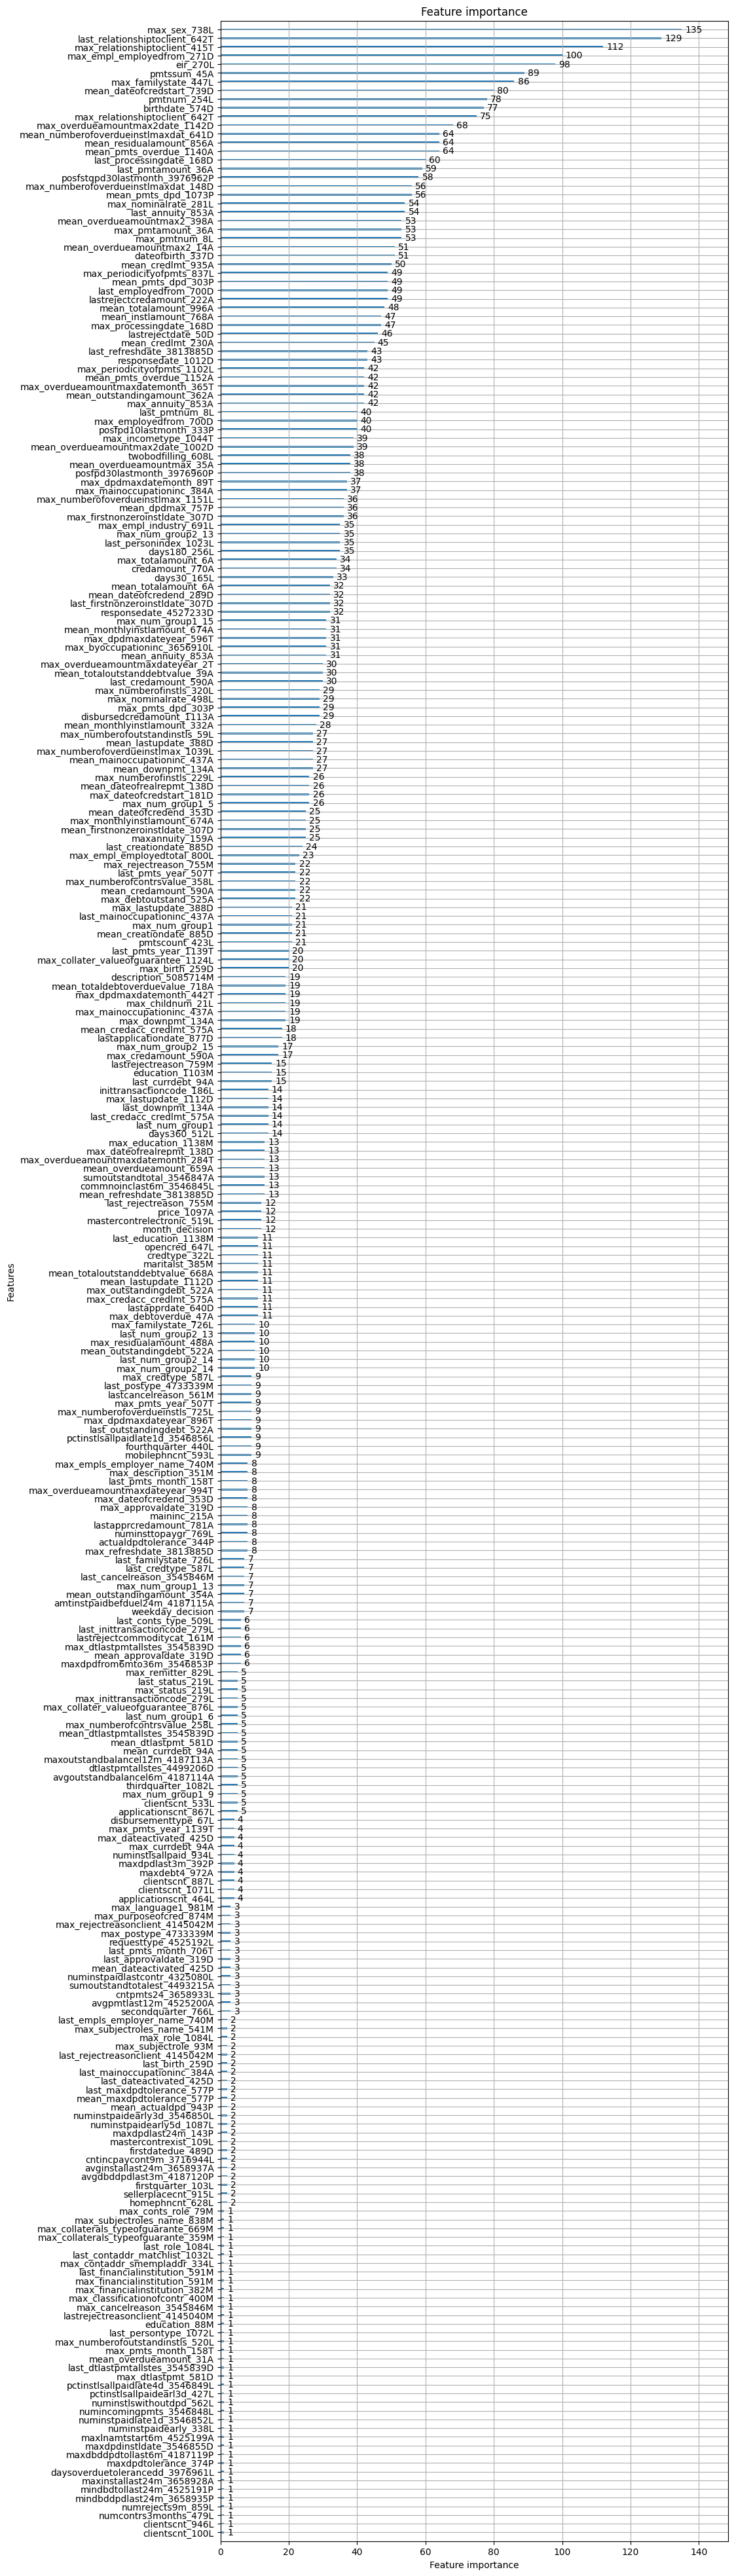

In [26]:
lgb.plot_importance(fitted_models[2], importance_type="split", figsize=(10,50))
plt.show()

In [27]:
features = X_train.columns
importances = fitted_models[2].feature_importances_
feature_importance = pd.DataFrame({'importance':importances,'features':features}).sort_values('importance', ascending=False).reset_index(drop=True)
feature_importance

drop_list = []
for i, f in feature_importance.iterrows():
    if f['importance']<80:
        drop_list.append(f['features'])
print(f"Number of features which are not important: {len(drop_list)} ")

print(drop_list)

Number of features which are not important: 378 
['pmtnum_254L', 'birthdate_574D', 'max_relationshiptoclient_642T', 'max_overdueamountmax2date_1142D', 'mean_residualamount_856A', 'mean_numberofoverdueinstlmaxdat_641D', 'mean_pmts_overdue_1140A', 'last_processingdate_168D', 'last_pmtamount_36A', 'posfstqpd30lastmonth_3976962P', 'max_numberofoverdueinstlmaxdat_148D', 'mean_pmts_dpd_1073P', 'last_annuity_853A', 'max_nominalrate_281L', 'mean_overdueamountmax2_398A', 'max_pmtamount_36A', 'max_pmtnum_8L', 'mean_overdueamountmax2_14A', 'dateofbirth_337D', 'mean_credlmt_935A', 'last_employedfrom_700D', 'max_periodicityofpmts_837L', 'lastrejectcredamount_222A', 'mean_pmts_dpd_303P', 'mean_totalamount_996A', 'mean_instlamount_768A', 'max_processingdate_168D', 'lastrejectdate_50D', 'mean_credlmt_230A', 'responsedate_1012D', 'last_refreshdate_3813885D', 'max_overdueamountmaxdatemonth_365T', 'max_periodicityofpmts_1102L', 'mean_outstandingamount_362A', 'mean_pmts_overdue_1152A', 'max_annuity_853A',

Submission

In [28]:
df_test = df_test.drop(columns=["WEEK_NUM"])
df_test = df_test.set_index("case_id")

In [29]:
y_pred = pd.Series(model.predict_proba(df_test)[:, 1], index=df_test.index)
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred
df_subm.to_csv("submission.csv")
df_subm

,score
case_id,
57543,0.020832
57549,0.038101
57551,0.014424
57552,0.036551
57569,0.030435
57630,0.014188
57631,0.040187
57632,0.034428
57633,0.027124


In [30]:
#X_test = df_test.drop(columns=["WEEK_NUM"])
#X_test = X_test.set_index("case_id")

#lgb_pred = pd.Series(model.predict_proba(X_test)[:, 1], index=X_test.index)

#df_subm = pd.read_csv(ROOT / "sample_submission.csv")
#df_subm = df_subm.set_index("case_id")

#df_subm["score"] = lgb_pred

#df_subm.head()

#df_subm.to_csv("submission.csv")

handle nan value (both numeric & categorical)
preprocess the minority categorical value (drop / keep)
float to int after ordinal encode
oversampling (smote? (considering date feature)
high dimension (pca)
create new features based on high fea_imp features ... ...

In [31]:
# X_resampled, y_resampled = SMOTE().fit_resample(X, y)